# Exploring Auto-encoders, Variational Auto-encoders and GANs for Images
# Part III - Generative Adversarial Network

In the excellent book _Hands on Machine Learning with Scikit-Learn, Keras, & Tensorflow_, Chapter 17 discusses autoencoders, variational autoencoders, and GANs.  The problems at the end of the chapter do not have answers provided, so I decided to try my hand at them.  Question 10 asks the reader to develop a variational autoencoder with an image dataset and use it to generate images.  Question 11 extends this to generating new images using a GAN.

In [Part I](https://www.kaggle.com/code/kirkdco/auto-encoder-vae-gan-part-i-auto-encoder?scriptVersionId=97158111), I start by generating a frequentist auto-encoder.

In [Part II](https://www.kaggle.com/code/kirkdco/auto-encoder-vae-gan-part-ii-vae), I develop a Variational Auto-encoder and show randomly generated images as well as imagest representing the average encoding for each class.

In Part III, I will finish with a Generative Adversarial Network.

You can find code for the book [here](https://github.com/ageron/handson-ml2), and my Github repository with my answers to exercises [here](https://github.com/KirkDCO/HandsOnML_Exercises).

# Finding an image dataset
For this exercise, I wanted to find an interesting image dataset that was not too complex but also not too simple.  A dataset with RGB images would also be nice.  After much searching through the [TensorFlow Datasets Catalog](https://www.tensorflow.org/datasets/catalog/overview) and [Kaggle Datasets](https://www.kaggle.com/datasets), I found the Kaggle [Flowers Dataset](https://www.kaggle.com/datasets/l3llff/flowers) consisting of 13,838 JPEG 96 x 96 images of 14 different flowers.  (The dataset changed with the addtion of a new flower type while I was working on this notebook, so the latest version may not match the numbers of files I've quoted or that you see in outputs, below.)  I added the dataset directly to this notebook from its location on Kaggle.

For this notebook, the dataset was reduced to only sunflowers, providing 1027 images of sunflowers.  In initial tests, including all flowers proved to be too complex given the number of images available, however, reduction to a single flower type led to much better results.  Also, the sunflowers appeared to be the most consistent with respect to their image composition.  The original images are 96 x 96 RGB images, but they were reduced to 48 x 48.  After some experimentation, the 96 x 96 images did not perform well, and the 48 x 48 seemed better behaved.  

First step is to import needed packages and set up global variables, and create a generator for the flower images.


In [1]:
# imports and globals

import tensorflow as tf
from tensorflow import keras
K = keras.backend

import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

BATCH_SIZE = 16 

IMG_WIDTH  = 48 
IMG_HEIGHT = 48 

KERNEL_SIZE = 4
ENCODING_SIZE = 32 

In [2]:
# create a training data generator 
training_generator = tf.keras.preprocessing.image_dataset_from_directory(
  r"e:\gan\flowers\sunflower",
  seed = 42,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE, 
  labels = None,
  color_mode = 'rgb'
)

training_generator = training_generator.prefetch(1)

Found 1027 files belonging to 1 classes.


# GAN

The GAN is based on the one presented in the book, but with a few modifications.

* The generator and discriminator have been adjusted for RGB images.
* Four convolutional layers are used, and the number of filters increases from 32 to 256.  I experimented with up to 4 convolutional layers and with more or less filters, but this seemed to produce the most reasonable results.
* Batch normalization was added to the discriminator and the results were very poor, so the final model has this removed.
* Dropout in the discriminator is critical.  Without it, the discriminator has a very hard time keeping pace with the generator.
* ReLU activations were tried in the generator, but generally produced very poor results.  SeLU performed well.
* A few experiments were done in which additional dense layers were added to the discriminator but these led to poorer results.
* The size of the encodings seemed to be very sensitive to the depth of the network and the size of the images. 

The interdependence of various hyperparameters made it very difficult to find a good balance witin the network.

In [3]:
generator = keras.Sequential([
  keras.layers.Dense(256 * 6 * 6, activation = "selu", input_shape = [ENCODING_SIZE]),
  keras.layers.Reshape([6, 6, 256]),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(filters = 128, kernel_size = KERNEL_SIZE, strides = 2,
                               padding = "same", activation = "selu",
                               kernel_initializer='lecun_normal'),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(filters = 64, kernel_size = KERNEL_SIZE, strides = 2,
                               padding = "same", activation = "selu",
                               kernel_initializer='lecun_normal'),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(filters = 32, kernel_size = KERNEL_SIZE, strides = 2,
                               padding = "same", activation = "selu",
                               kernel_initializer='lecun_normal'),
  keras.layers.Conv2DTranspose(filters = 3, kernel_size = KERNEL_SIZE, strides = 1,
                               padding = 'same', activation = 'sigmoid')
])
generator.summary()   

discriminator = keras.Sequential([
  keras.layers.Conv2D(32, input_shape = [IMG_WIDTH, IMG_HEIGHT, 3], kernel_size = KERNEL_SIZE, 
                      strides = 1, padding = 'same', activation = keras.layers.LeakyReLU(0.2)),
  keras.layers.Dropout(0.25),                      
  keras.layers.Conv2D(64, kernel_size = KERNEL_SIZE, strides = 2,
                      padding = 'same', activation = keras.layers.LeakyReLU(0.2)),
  keras.layers.Dropout(0.25),                      
  keras.layers.Conv2D(128, kernel_size = KERNEL_SIZE, strides = 2,
                      padding = 'same', activation = keras.layers.LeakyReLU(0.2)),
  keras.layers.Dropout(0.25),                      
  keras.layers.Conv2D(256, kernel_size = KERNEL_SIZE, strides = 2,
                      padding = 'same', activation = keras.layers.LeakyReLU(0.2)),
  keras.layers.Dropout(0.25),                      
  keras.layers.Flatten(),
  keras.layers.Dense(1, activation = 'sigmoid')                                  
])
discriminator.summary()

gan = keras.models.Sequential([generator, discriminator])
gan.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9216)              304128    
                                                                 
 reshape (Reshape)           (None, 6, 6, 256)         0         
                                                                 
 batch_normalization (BatchN  (None, 6, 6, 256)        1024      
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 12, 12, 128)      524416    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 12, 12, 128)      512       
 hNormalization)                                                 
                                                        

# Utility Functions

Some utility functions from the book were used with some modifications.

* In the _train_gain_ function, I added two accumulators with the actual image classes and the predicted classes from the discriminator.  This allowed me to add a confusion matrix and accuracy metric after each epoch to see how the discriminator performed.  This was very helpful to see when the discriminator was very poor and thus not providing good feedback to the generator.  
* A plotting option was added to allow showing examples of generated (top row) and actual sunflowers (bottom row) every so often. 

In [4]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols * 3, n_rows * 3))

    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

def train_gan(gan, dataset, BATCH_SIZE, ENCODING_SIZE, n_epochs = 50, plot_frequency = 10, learning_rate = 0.01):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        preds = []
        actuals = []
        for X_batch in dataset:
          # give some feedback during the epoch
          print("=", end = '')
          X_batch /= 255

          # phase 1 - training the discriminator
          noise = tf.random.normal(shape=[len(X_batch), ENCODING_SIZE])
          generated_images = generator(noise)
          X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
          y1 = tf.constant([[0.]] * len(X_batch) + [[1.]] * len(X_batch))
          y1 += 0.05 * tf.random.uniform(tf.shape(y1)) # add random noise to labels - this seems to help training significantly
          discriminator.trainable = True
          discriminator.train_on_batch(X_fake_and_real, y1)

          # capture the actual and predicted values for later
          actuals.extend([y.numpy()[0] for y in y1])
          preds.extend([y[0] for y in discriminator.predict(X_fake_and_real).tolist()])
          
          # phase 2 - training the generator
          noise = tf.random.normal(shape=[len(X_batch), ENCODING_SIZE])
          y2 = tf.constant([[1.]] * len(X_batch))
          discriminator.trainable = False
          gan.train_on_batch(noise, y2)

        # print out a confusion matrix to see how the discriminator is doing
        # commented out here to save space
        print()
        print(confusion_matrix([1 if a > 0.5 else 0 for a in actuals], 
                               [1 if p > 0.5 else 0 for p in preds]))
        print('accuracy: ', accuracy_score([1 if a > 0.5 else 0 for a in actuals], 
                                           [1 if p > 0.5 else 0 for p in preds]))

        # only plot every 10 epochs
        if epoch % plot_frequency == 0:
          plot_multiple_images(X_fake_and_real, 3)
          plt.show()
          
    plot_multiple_images(X_fake_and_real, 3)
    plt.show()

Epoch 1/100
1/1 [==============================] - 0s 43ms/step

[[493 534]
 [190 837]]
accuracy:  0.6475170399221032


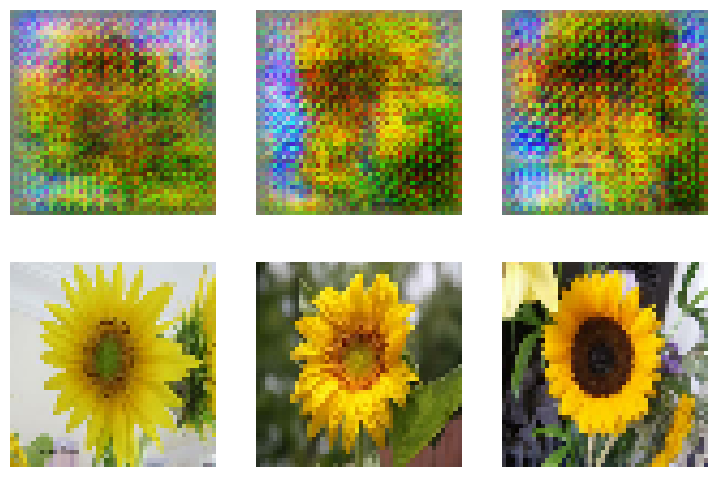

Epoch 2/100
1/1 [==============================] - 0s 16ms/step

[[621 406]
 [172 855]]
accuracy:  0.7185978578383642
Epoch 3/100
1/1 [==============================] - 0s 15ms/step

[[611 416]
 [206 821]]
accuracy:  0.697176241480039
Epoch 4/100
1/1 [==============================] - 0s 16ms/step

[[573 454]
 [169 858]]
accuracy:  0.6966893865628043
Epoch 5/100
1/1 [==============================] - 0s 17ms/step

[[647 380]
 [193 834]]
accuracy:  0.7210321324245375
Epoch 6/100
1/1 [==============================] - 0s 16ms/step

[[724 303]
 [173 854]]
accuracy:  0.7682570593963
Epoch 7/100
1/1 [==============================] - 0s 16ms/step

[[773 254]
 [251 776]]
accuracy:  0.7541382667964946
Epoch 8/100
1/1 [==============================] - 0s 17ms/step

[[840 187]
 [206 821]]
accuracy:  0.808666017526777
Epoch 9/100
1/1 [==============================] - 0s 16ms/step

[[884 143]
 [200 827]]
accuracy:  0.8330087633885103
Epoch 10/100
1/1 [==============================] - 0s 17ms/s

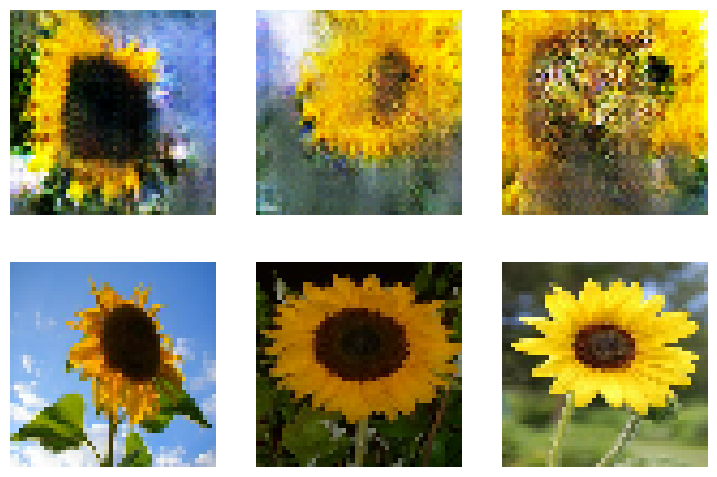

Epoch 52/100
1/1 [==============================] - 0s 17ms/step

[[974  53]
 [ 38 989]]
accuracy:  0.9556962025316456
Epoch 53/100
1/1 [==============================] - 0s 19ms/step

[[ 986   41]
 [  22 1005]]
accuracy:  0.9693281402142162
Epoch 54/100
1/1 [==============================] - 0s 17ms/step

[[973  54]
 [ 43 984]]
accuracy:  0.9527750730282376
Epoch 55/100
1/1 [==============================] - 0s 19ms/step

[[978  49]
 [ 37 990]]
accuracy:  0.9581304771178188
Epoch 56/100
1/1 [==============================] - 0s 19ms/step

[[ 953   74]
 [  26 1001]]
accuracy:  0.9513145082765336
Epoch 57/100
1/1 [==============================] - 0s 17ms/step

[[ 981   46]
 [  21 1006]]
accuracy:  0.9673807205452775
Epoch 58/100
1/1 [==============================] - 0s 19ms/step

[[ 973   54]
 [  22 1005]]
accuracy:  0.9629990262901655
Epoch 59/100
1/1 [==============================] - 0s 17ms/step

[[ 968   59]
 [  26 1001]]
accuracy:  0.9586173320350535
Epoch 60/100
1/1 [==========

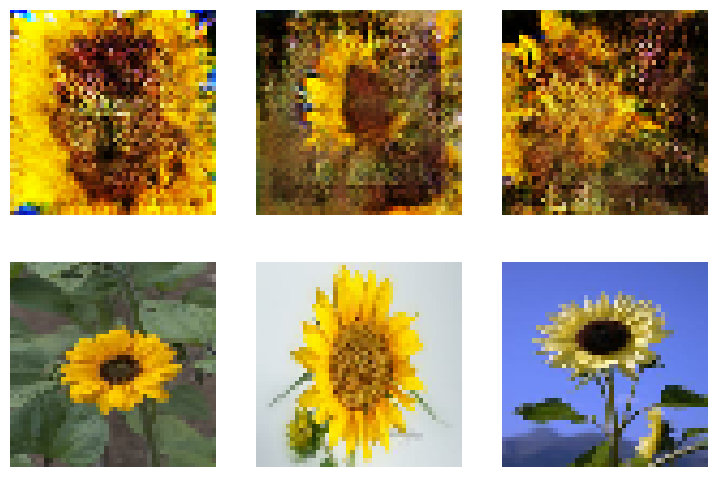

In [5]:
# clear the session for a clean run
keras.backend.clear_session()
tf.random.set_seed(42)

discriminator.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.RMSprop())
discriminator.trainable = False
gan.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.RMSprop())

train_gan(gan, training_generator, BATCH_SIZE, ENCODING_SIZE, n_epochs = 100, plot_frequency = 50)

# Conclusions

In early epochs, the generator essentially learns the color palette first.  In some examples, depending on the size of the images, the depth of the network, etc., the first few epoch were clearly noise in the wrong color space, but would quickly change to the right set of yellows and reds.  Within a few more epochs, a color separation in the images with blue on top, yellow in the middle, and darker (generally greenish) on the bottom, showing that the generator was learing the general structure of the images.  This structure typically consisted of a central, yellow sunflower, framed on a blue sky and having dark green leaves on the bottom.  Along the way, more circular shapes would begin to emerge, and eventually some images that had some sunflower characteristics were produced.  Granted, these will not fool anyone, but there's clearly a learning process happening.

It was clear that larger images were much harder, and reducing the images to 48 x 48 helped.  Reducing the images further was helpful, but then the real images were themselves less convincing.  

Deeper network with 4 or 5 convolutional layers and as many as 1024 filters in the deepest layer also improved the images, but only slightly.

Clear limitations of this approach include:
* there were only 1027 images in the real image set
* the images were not very consistently framed - some have wonderfully centered flowers, but there are many camera angles, and many images of fields of sunflowers
* much larger and more complex networks might help, but more training data will probably be more impactful

Also interesting is the periodicity observed in the generated images.  There are repeated pattern blocks that are clearly reflective of the underlying network structure and weights.  I'm quite surprised at the degree of periodicity, however.  A more thorough investigation of the weights of each layer of the network would be interesting to determine why there are such periodic or symmetric structures.